<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/dev/GNN%20model%20ECG%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset prepare

In [ ]:
!pip install --quiet --upgrade gensim
import os
os.kill(os.getpid(), 9)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from gensim.models import Word2Vec

In [2]:
# загружаем полный датасет
raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=15000)
raw_table_data.head(10)

,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report_0,report_1,report_2,...,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,19557662,27,40000017,6848296,0,8:44 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,659,40,128,170,258,518,81,77,79
1,18477137,93,40000029,6848296,0,9:54 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,722,40,124,162,246,504,77,75,70
2,16598616,3,40000035,6376932,1,9:07 AM,28.06.2015,Sinus tachycardia,NaN,Normal ECG except for rate,...,60 Hz notch Baseline filter,600,40,130,162,244,474,79,72,77
3,16368287,7,40000079,6214760,1,5:14 PM,15.07.2015,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,659,40,146,180,254,538,79,66,69
4,18370366,2,40000084,6632385,0,1:52 PM,27.09.2015,Sinus rhythm,NaN,NaN,...,<not specified>,659,368,29999,504,590,868,84,80,77
5,15606157,55,40000089,6632385,0,2:29 PM,29.10.2013,Sinus rhythm,NaN,NaN,...,<not specified>,822,365,29999,499,592,852,26,46,30
6,12576058,43,40000115,6852956,1,12:54 PM,23.03.2016,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,952,40,146,198,282,598,24,80,20
7,14691089,1,40000143,6551957,0,10:01 AM,10.12.2016,Sinus rhythm,rSr'(V1) - probable normal variant,Low QRS voltages in precordial leads,...,60 Hz notch Baseline filter,923,40,140,188,278,594,26,86,13
8,14144725,7,40000144,6924910,0,7:24 AM,11.12.2011,Sinus rhythm with PAC(s).,NaN,Borderline ECG,...,60 Hz notch Baseline filter,952,40,180,196,294,610,59,-17,3
9,16089780,2,40000152,6919786,0,12:35 PM,13.12.2011,Sinus rhythm,Extensive T wave changes may be due to myocard...,NaN,...,60 Hz notch Baseline filter,1000,40,156,178,274,584,8,-11,19


In [3]:
# Предобрабатываем данные словестных репортов word2vec в числовой вектор

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = raw_table_data[(raw_table_data[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Фиксим имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})
full_df_filtered = full_df_filtered.drop(columns = ['bandwidth', 'filtering'])

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

# Разбиваем столбец с текстовым отчетом на токены
words = [text.split() for text in full_df_filtered['report']]

# Обучаем модель Word2Vec
w2v_model = Word2Vec(words)

# Функция для получения среднего эмбеддинга строки
def get_sentence_embedding(sentence):
    words = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

# Применяем функцию ко всей колонке и переводим каждый вектор в одно число
full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

full_df_filtered.head()

,subject_id,Count_subj,study_id,cart_id,eeg_time,eeg_date,report,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,19557662,27,40000017,6848296,8:44 AM,27.06.2015,0.035814,659,40,128,170,258,518,81,77,79,0
1,18477137,93,40000029,6848296,9:54 AM,27.06.2015,0.035814,722,40,124,162,246,504,77,75,70,0
2,16598616,3,40000035,6376932,9:07 AM,28.06.2015,-0.007411,600,40,130,162,244,474,79,72,77,1
3,16368287,7,40000079,6214760,5:14 PM,15.07.2015,0.002037,659,40,146,180,254,538,79,66,69,1
6,12576058,43,40000115,6852956,12:54 PM,23.03.2016,0.002037,952,40,146,198,282,598,24,80,20,1


In [4]:
# make new dataset from old columns
table_data = full_df_filtered[['subject_id','study_id','eeg_date','report','rr_interval','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status']].copy()
table_data['eeg_date'] = pd.to_datetime(table_data['eeg_date'],dayfirst=True)
table_data = table_data.sort_values(by=['subject_id', 'eeg_date'])

#table_data = table_data.head(1000)

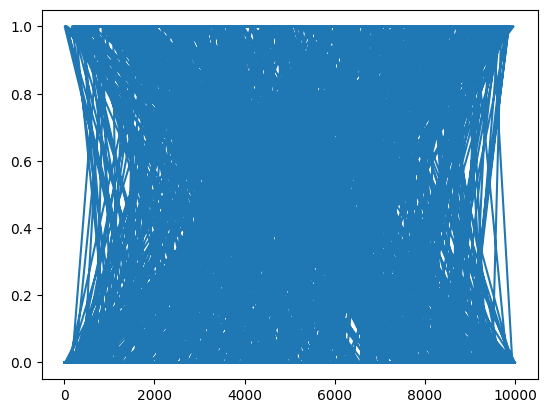

In [5]:
duplicate_index = table_data['subject_id'].duplicated()
plt.plot(duplicate_index)

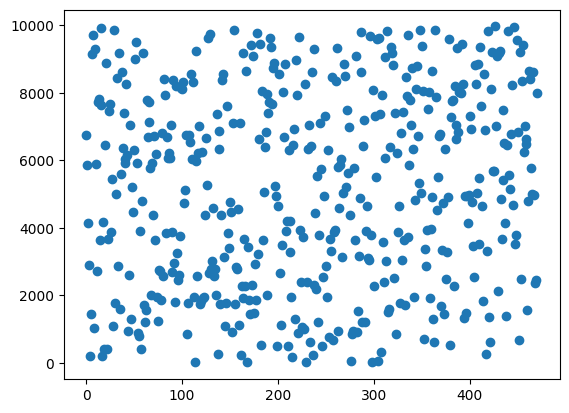

In [6]:
duplicate_index = duplicate_index[duplicate_index[:]==True].index
plt.scatter(range(0,len(duplicate_index)), duplicate_index)

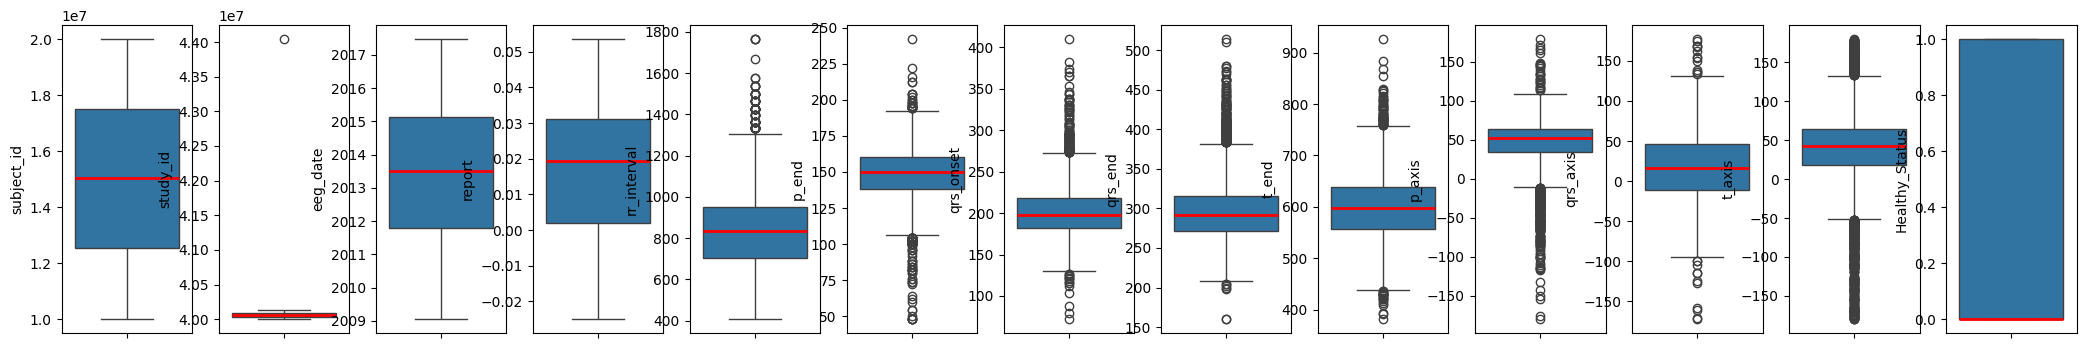

In [7]:
n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data, medianprops={"color": "r", "linewidth": 2})

Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

# Graph Network Visualization

In [101]:
import os
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder

In [136]:
encoder = LabelEncoder()

In [137]:
text_columns = table_data.columns
text_columns

Index(['subject_id', 'study_id', 'eeg_date', 'report', 'rr_interval', 'p_end',
       'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis',
       'Healthy_Status'],
      dtype='object')

In [138]:
ecg_table = table_data

In [139]:
for col in text_columns:
    ecg_table[col] = encoder.fit_transform(ecg_table[col])

In [185]:
ecg_table.describe()

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
count,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000,7046.000000
mean,3289.004825,3522.500000,1137.981692,1147.893131,70.569543,42.223247,46.484246,48.086716,94.264121,143.204797,115.259296,202.692450,0.284842
std,1895.896433,2034.149331,629.443198,985.490574,17.770397,9.264000,14.719520,18.704022,30.327448,26.915733,39.107011,48.547046,0.451371
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1653.250000,1761.250000,594.000000,206.000000,61.000000,37.000000,37.000000,36.000000,74.000000,131.000000,88.000000,180.000000,0.000000
50%,3281.500000,3522.500000,1148.500000,913.500000,74.000000,43.000000,45.000000,46.000000,94.000000,149.000000,115.500000,204.000000,0.000000
75%,4925.750000,5283.750000,1692.750000,1999.750000,83.000000,48.000000,55.000000,58.000000,114.000000,161.000000,145.000000,226.000000,1.000000
max,6574.000000,7045.000000,2290.000000,3198.000000,110.000000,74.000000,119.000000,137.000000,206.000000,228.000000,234.000000,341.000000,1.000000


## edge end nodes vizualisation

In [ ]:
import networkx as nx

In [ ]:
qwe = ecg_table['subject_id'].unique()
asd = ecg_table.duplicated(subset=['subject_id'])
print(len(qwe))
print(len(ecg_table['subject_id']))

6575
7046


In [186]:
# Находим дубликаты по 'subject_id'
duplicated_rows = table_data[table_data.duplicated(subset=['subject_id'], keep=False)]

# Сортируем для удобства (опционально)
duplicated_rows = duplicated_rows.sort_values(by='subject_id')
duplicated_rows.head()

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
2248,62,1600,426,206,85,55,65,62,121,89,104,209,1
6734,62,4691,647,1635,79,43,72,71,120,148,140,210,0
5850,62,4065,717,76,88,38,42,34,89,158,169,188,1
7433,69,5157,124,1164,90,31,42,39,99,152,116,191,0
4137,69,2874,1349,14,105,50,40,38,130,153,87,171,0


In [187]:
duplicated_rows=duplicated_rows.head(1000)
graph_model = pd.DataFrame(
    {
        "source": duplicated_rows['subject_id'],
        "target": duplicated_rows['report'],
        "edge_key": duplicated_rows['eeg_date'],
        "weight": duplicated_rows['report'],
        "status": duplicated_rows['Healthy_Status'],
    }
)

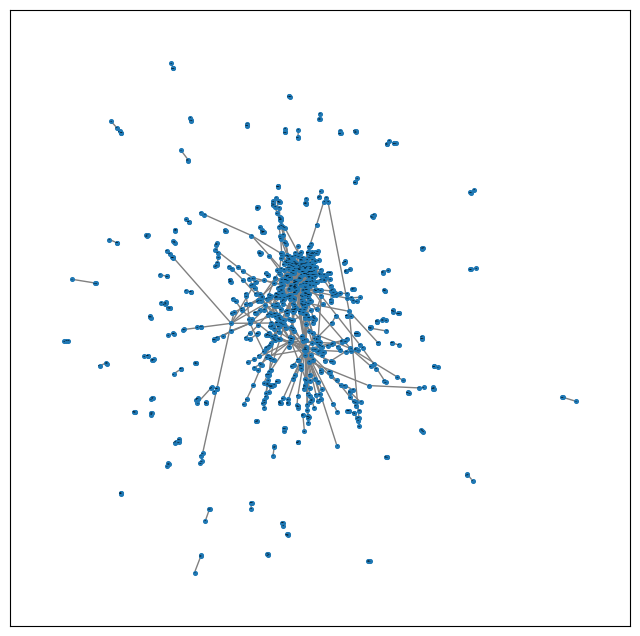

In [ ]:

G = nx.from_pandas_edgelist(
    graph_model,
    edge_key="edge_key",
    edge_attr=["weight", "status"],
    create_using=nx.MultiGraph(),
)

plt.figure(figsize=(8, 8))
nx.draw_networkx(G, pos=nx.spring_layout(G), node_size=7, font_size = 0,edge_color ='grey')

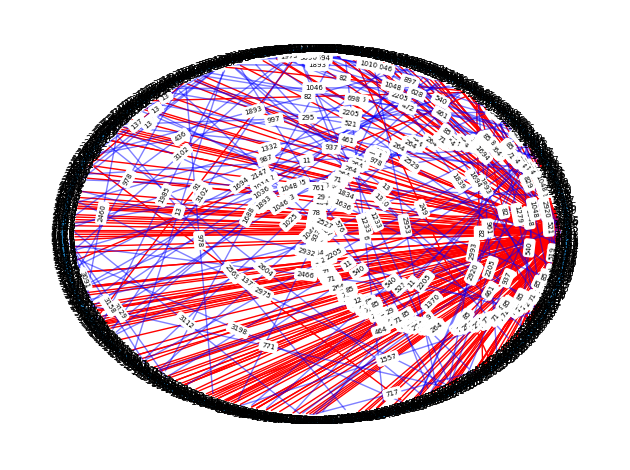

In [ ]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] <= 0.5]

pos = nx.circular_layout(G)#, seed=13)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=7)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=1, edge_color="r")
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=1, alpha=0.5, edge_color="b", style="solid"
)

# node labels
nx.draw_networkx_labels(G, pos, font_size=7, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=5)

ax = plt.gca()
#ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] <= 0.5]

pos = nx.kamada_kawai_layout(G)#, seed=13)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=1)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=1, alpha=0.5, edge_color="r")
nx.draw_networkx_edges(G, pos, edgelist=esmall, width=1, alpha=0.5, edge_color="b", style="solid")

# node labels
#nx.draw_networkx_labels(G, pos, font_size=0, font_family="sans-serif")
# edge weight labels
#edge_labels = nx.get_edge_attributes(G, "weight")
#nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=5)

ax = plt.gca()
#ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

#Graph Neural Network vs MLP

In [142]:
import tensorflow as tf

In [323]:
ecg_table.head()

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
4448,0,3093,1470,3059,88,28,22,24,79,52,127,144,0
8586,1,6006,252,1776,85,42,52,53,106,111,118,167,0
1917,2,1352,1736,2224,68,35,80,75,147,136,96,240,0
3849,3,2680,570,2096,67,46,52,59,102,146,92,287,0
8139,4,5704,47,310,68,31,38,60,104,151,41,222,0


In [325]:
class_values = sorted(ecg_table["Healthy_Status"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
class_values

[0, 1]

In [326]:
train_data, test_data = [], []

for _, group_data in ecg_table.groupby("subject_id"):
    # Select around 80% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (5584, 13)
Test data shape: (1462, 13)


In [332]:
feature_names = list(set(ecg_table.columns) - {"subject_id", "study_id", "Healthy_Status"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["Healthy_Status"]
y_test = test_data["Healthy_Status"]

In [333]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_features            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block1 (Sequential)   │ (None, 32)             │          1,576 │ input_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block2 (Sequential)   │ (None, 32)             │          2,368 │ ffn_block1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skip_connection2 (Add)    │ (None, 32)             │              0 │ ffn_block1[0][0],      │
│                           │                        │                │ ffn_block2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block3 (Sequential)   │ (None, 32)             │          2,368 │ skip_connection2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skip_connection3 (Add)    │ (None, 32)             │              0 │ skip_connection2[0][0… │
│                           │                        │                │ ffn_block3[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block4 (Sequential)   │ (None, 32)             │          2,368 │ skip_connection3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skip_connection4 (Add)    │ (None, 32)             │              0 │ skip_connection3[0][0… │
│                           │                        │                │ ffn_block4[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ffn_block5 (Sequential)   │ (None, 32)             │          2,368 │ skip_connection4[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ skip_connection5 (Add)    │ (None, 32)             │              0 │ skip_connection4[0][0… │
│                           │                        │                │ ffn_block5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ logits (Dense)            │ (None, 2)              │             66 │ skip_connection5[0][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,114 (43.41 KB)

 Trainable params: 10,518 (41.09 KB)

 Non-trainable params: 596 (2.33 KB)

In [334]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 30
batch_size = 256

In [335]:

def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [336]:

def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [337]:

def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [338]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - acc: 0.5870 - loss: 1.4113 - val_acc: 0.7208 - val_loss: 5.3393
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.7423 - loss: 0.5424 - val_acc: 0.7208 - val_loss: 4.0022
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.7462 - loss: 0.4853 - val_acc: 0.7208 - val_loss: 2.2339
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.7720 - loss: 0.4555 - val_acc: 0.7208 - val_loss: 1.0025
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.7907 - loss: 0.4266 - val_acc: 0.7220 - val_loss: 0.6380
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.7923 - loss: 0.4198 - val_acc: 0.7232 - val_loss: 0.5073
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.7916 - loss: 0.4110 - val_acc: 0.7232 - val_loss: 0.4489
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.8008 - loss: 0.3967 - val_acc: 0.7613 - val_loss: 0.3513
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.787

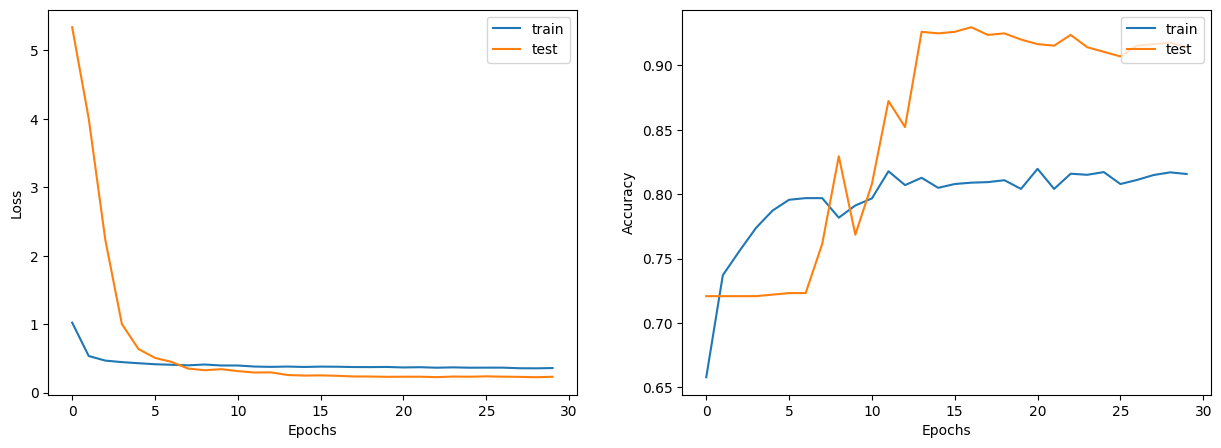

In [339]:
display_learning_curves(history)

In [340]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 93.91%


In [341]:

def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")


In [342]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
Instance 1:
- 0: 90.22%
- 1: 9.78%
Instance 2:
- 0: 90.22%
- 1: 9.78%


In [345]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = ecg_table[["subject_id", "study_id"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    ecg_table.sort_values("subject_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 7046)
Nodes shape: (7046, 10)


In [346]:

def create_gru(hidden_units, dropout_rate):
    inputs = keras.layers.Input(shape=(2, hidden_units[0]))
    x = inputs
    for units in hidden_units:
      x = layers.GRU(
          units=units,
          activation="tanh",
          recurrent_activation="sigmoid",
          return_sequences=True,
          dropout=dropout_rate,
          return_state=False,
          recurrent_dropout=dropout_rate,
      )(x)
    return keras.Model(inputs=inputs, outputs=x)


class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gru":
            self.update_fn = create_gru(hidden_units, dropout_rate)
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim].
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [347]:

def create_gru(hidden_units, dropout_rate):
    inputs = keras.layers.Input(shape=(2, hidden_units[0]))
    x = inputs
    for units in hidden_units:
      x = layers.GRU(
          units=units,
          activation="tanh",
          recurrent_activation="sigmoid",
          return_sequences=True,
          dropout=dropout_rate,
          return_state=False,
          recurrent_dropout=dropout_rate,
      )(x)
    return keras.Model(inputs=inputs, outputs=x)


class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gru":
            self.update_fn = create_gru(hidden_units, dropout_rate)
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim].
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [348]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

#print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

Model: "gnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv1 (GraphConvLayer)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv2 (GraphConvLayer)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ postprocess (Sequential)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ logits (Dense)                       │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [349]:
x_train = train_data.subject_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - acc: 0.5680 - loss: 35.3215 - val_acc: 0.7064 - val_loss: 2.7218
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - acc: 0.6163 - loss: 2.6292 - val_acc: 0.5800 - val_loss: 0.8412
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - acc: 0.5563 - loss: 1.4298 - val_acc: 0.5334 - val_loss: 0.7760
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - acc: 0.6052 - loss: 0.8313 - val_acc: 0.3998 - val_loss: 1.0666
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - acc: 0.6124 - loss: 0.7875 - val_acc: 0.6444 - val_loss: 0.6556
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - acc: 0.6058 - loss: 0.8001 - val_acc: 0.7208 - val_loss: 0.9905
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - acc: 0.6343 - loss: 0.9041 - val_acc: 0.7184 - val_loss: 0.6884
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - acc: 0.6577 - loss: 0.6828 - val_acc: 0.7112 - val_loss: 0.6139
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - acc:

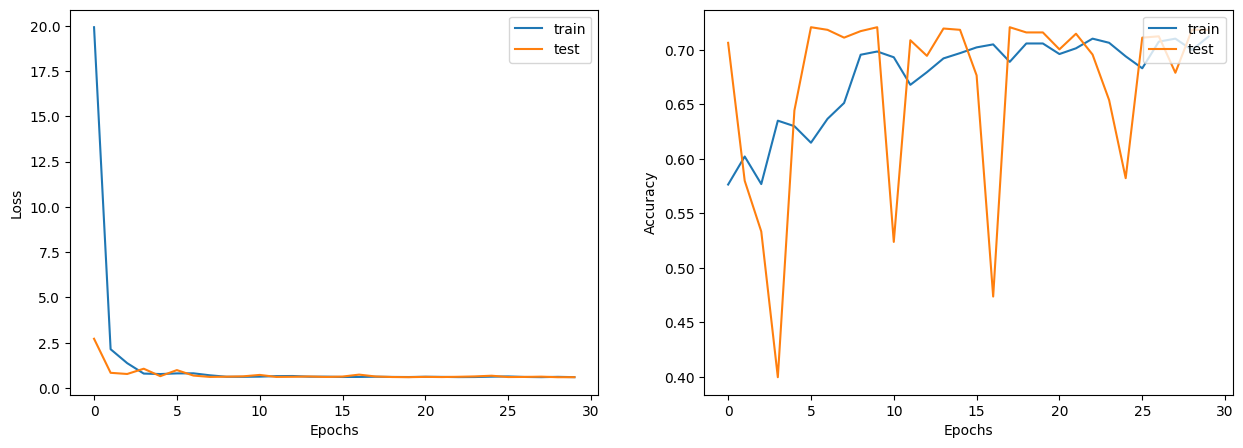

In [350]:
display_learning_curves(history)

In [353]:
x_test = test_data.subject_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 72.3%


In [358]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in ecg_table.groupby("Healthy_Status"):
    subject_patient = list(group.subject_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_patient, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(ecg_table.subject_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [359]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (7046, 10)
Original edges shape: (2, 7046)
New node_features shape: (7048, 10)
New edges shape: (2, 7060)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
Instance 1:
- 0: 52.05%
- 1: 47.95%
Instance 2:
- 0: 52.08%
- 1: 47.92%


In [403]:
view_ecg_table = ecg_table.sample(n=100)

graph_model = pd.DataFrame(
    {
        "source": view_ecg_table['subject_id'],
        "target": view_ecg_table['report'],
        "edge_key": view_ecg_table['eeg_date'],
        "weight": view_ecg_table['report'],
        "status": view_ecg_table['Healthy_Status'],
    }
)

graph_model.head()

,source,target,edge_key,weight,status
1686,5400,1306,1451,1306,0
8085,182,206,1794,206,1
8338,5524,2612,2104,2612,0
2020,5626,1963,1539,1963,0
2806,2243,1099,2215,1099,0


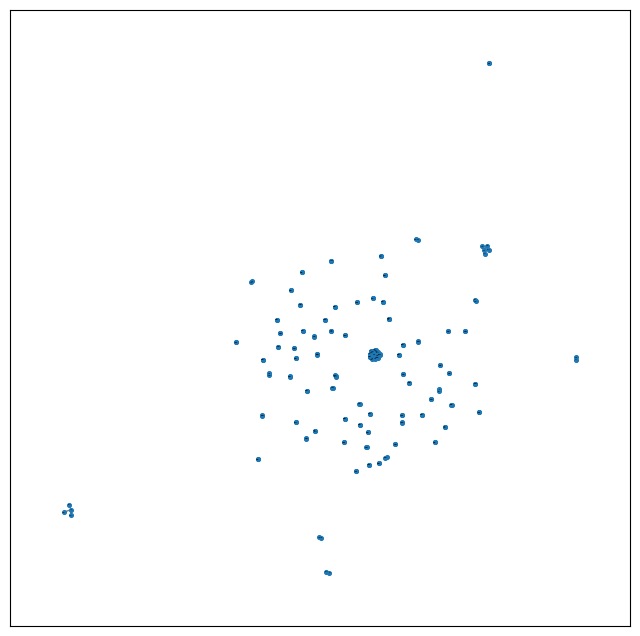

In [406]:

G = nx.from_pandas_edgelist(
    graph_model,
    edge_key="edge_key",
    edge_attr=["weight", "status"],
    create_using=nx.MultiGraph(),
)

plt.figure(figsize=(8, 8))

nx.draw_networkx(G, pos=nx.spring_layout(G), node_size=7, font_size = 1,edge_color ='grey')



# Torch framework graph GCN model

In [13]:
!pip install -q torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.8 MB/s eta 0:00:00


In [39]:
import torch
torchversion = torch.__version__

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

import networkx as nx

In [24]:
duplicated_rows.head()

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
2248,10108435,40029160,2011-04-21,0.002037,983,174,238,324,652,-8,5,47,1
6734,10108435,40085519,2011-12-19,0.027649,895,150,252,342,650,51,41,48,0
5850,10108435,40074083,2012-03-04,-0.008011,1034,140,192,268,588,61,70,26,1
7433,10123949,40093465,2010-04-14,0.022097,1071,126,192,278,608,55,17,29,0
4137,10123949,40052905,2014-02-11,-0.020410,1463,164,188,276,670,56,-12,9,0


Data(x=[7, 1], edge_index=[2, 35], edge_attr=[35, 1])


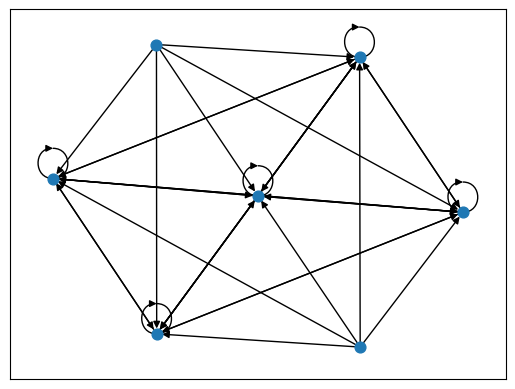

In [48]:
# just simple example
n1 = np.repeat(np.array([0,1,2,3,4,5,6]),5)
n2 = np.array([0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4])
cat = np.stack((n1,n2), axis=0)
e = torch.tensor(cat, dtype=torch.long)
edge_index = e.t().clone().detach()
edge_attr = torch.tensor(np.random.rand(35,1))

x = torch.tensor([[0], [0], [0], [0], [0], [1], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr = edge_attr)
print(data)
# Data(edge_attr=[35, 1], edge_index=[2, 35], x=[7, 1])

networkX_graph = to_networkx(data, node_attrs=["x"], edge_attrs=["edge_attr"])


# Draw the graph
pos = nx.spring_layout(networkX_graph, k=2)
nx.draw_networkx(
    networkX_graph,
    pos=pos,
    with_labels=False,
    node_size=60,
)
plt.show()


In [85]:
edge_index = torch.from_numpy(graph_model[["source", "target"]].to_numpy())
#node_features = torch.from_numpy(np.array(graph_model["weight"].tolist()))
node_features = torch.from_numpy(np.array(graph_model["weight"].to_numpy()))

#label = torch.from_numpy(np.array(graph_model["status"].tolist()))
label = torch.from_numpy(graph_model[["status"]].to_numpy())

edge_attr = torch.from_numpy(graph_model[["weight"]].to_numpy())

#data = Data(x=x, edge_index=edge_index.T)
data = Data(x=node_features,
            #edge_index=edge_index,
            edge_index=edge_index.t().contiguous(),
            edge_attr=edge_attr,
            y=label, #you can add more arguments as you like
                    )
data
#data.num_features

Data(x=[888], edge_index=[2, 888], edge_attr=[888, 1], y=[888, 1])

In [82]:
# Print information about the dataset
print(f'Number of nodes: {data.x.shape[0]}')
#print(f'Number of features: {dataset.num_features}')
#print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Number of nodes: 888

Graph:
------
Edges are directed: True
Graph has isolated nodes: False
Graph has loops: False


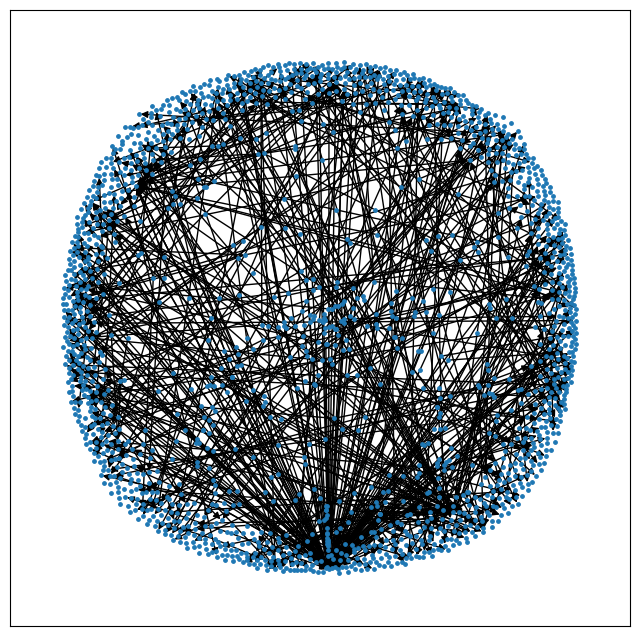

In [86]:
graph = to_networkx(data, node_attrs=["x"], edge_attrs=["edge_attr"])
# Draw the graph

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(graph)#, k=2)
nx.draw_networkx(
    graph,
    pos=pos,
    with_labels=False,
    edge_color='grey',
    node_size=6,
)
plt.show()

In [87]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)


def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 50

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [88]:
data.num_node_features

1

In [89]:
%%time

# Create GCN model
#gcn = GCN(dataset.num_features, 16, dataset.num_classes)
gcn = GCN(1, 16, 1)

print(gcn)

# Train
train(gcn, data)

# Test
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1, 16)
  (gcn2): GCNConv(16, 1)
)


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got -2)